# Evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *
from plotnine import *

In [2]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

In [3]:
MODEL_COLORS = {
    'Ensemble': '#009E73',
    'LightGBM': '#B30000',
    'LightGBM-NoCovariates': '#B30000',
    'LightGBM-NoCovid': '#B30000',
    'LightGBM-Oracle': '#B30000',
    'LightGBM-Skip': '#B30000',
    'LightGBM-Uncorrected': '#B30000',
    'TSMixer': '#E69F00',
    'TSMixer-NoCovariates': '#E69F00',
    'TSMixer-NoCovid': '#E69F00',
    'TSMixer-Oracle': '#E69F00',
    'TSMixer-Skip': '#E69F00',
    'TSMixer-Uncorrected': '#E69F00',
    'hhh4': '#3C4AAD',
    'hhh4-NoCovid': '#3C4AAD',
    'hhh4-Oracle': '#3C4AAD',
    'hhh4-Skip': '#3C4AAD',
    'hhh4-Uncorrected': '#3C4AAD',
    'Nowcast': '#56B4E9',
    'Historical': '#000000',
    'Persistence' : '#80471C',
}

In [72]:
MODEL_ORDER = ['Nowcast', 'Ensemble', 
               'LightGBM', 'LightGBM-NoCovariates', 'LightGBM-NoCovid', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected',
               'TSMixer', 'TSMixer-NoCovariates', 'TSMixer-NoCovid', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',
               'hhh4', 'hhh4-NoCovid', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected', 'Persistence', 'Historical']

In [5]:
MAIN_MODELS = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Historical', 'Persistence']

In [55]:
MODEL_NAMES = {'KIT-MeanEnsemble': 'Ensemble',
 'KIT-LightGBM': 'LightGBM',
 'KIT-TSMixer': 'TSMixer',
 'KIT-hhh4': 'hhh4'}

In [56]:
def load_predictions(models=None, start='2024-10-10', end='2025-03-27', exclude_christmas=True,
                     include_median=True, include_truth=True, target=True):
    files = glob.glob(f'../data/submissions/**/*.csv', recursive=True)
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-', 5)[-1][:-4] 
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source='icosari', disease='sari', target=target)
    if exclude_christmas:
        df = df[df.forecast_date != '2023-12-28']
        
    df.model = df.model.replace(MODEL_NAMES)
    
    if models is None: 
        models = MODEL_NAMES.values()
    df = df[df.model.isin(models)]

    return df[df.forecast_date.between(start, end)].reset_index(drop=True)

In [76]:
df = load_predictions()

In [77]:
df.model.unique()

array(['TSMixer', 'LightGBM', 'Ensemble', 'hhh4'], dtype=object)

In [59]:
# df_nowcasts = load_nowcasts(quantiles=QUANTILES)

# df = pd.concat([df, df_nowcasts], ignore_index=True)

In [62]:
# df.loc[df.model == 'LightGBM', 'value'] = df[df.model == 'LightGBM'].value.apply(lambda x: round(x, -1))

In [63]:
# df.loc[df.model == 'LightGBM', 'value'] = df[df.model == 'LightGBM'].value.round()

# Compute scores

#### National level

In [78]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,TSMixer,638.421829,87.550881,531.107444,1257.080153,0.565217,0.978261
1,hhh4,525.722050,310.993789,445.779503,1282.495342,0.445652,0.945652
2,Ensemble,567.370526,117.239013,605.454303,1290.063842,0.562500,0.958333
3,LightGBM,522.164074,61.146627,1277.533452,1860.844153,0.510870,0.891304


#### Age groups

In [79]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,TSMixer,120.109778,24.714314,97.575059,242.399151,0.557971,0.965580
1,Ensemble,121.812313,41.495416,83.191147,246.498875,0.536458,0.968750
2,hhh4,141.208592,83.059783,60.433489,284.701863,0.541667,0.954710
3,LightGBM,97.046809,32.381574,189.449870,318.878253,0.342391,0.835145


In [80]:
# evaluate_models(df, 'age', by_horizon=True)

In [81]:
# evaluate_models(df, 'age', by_age=True)

# Prepare scores

In [82]:
df_national = evaluate_models(df, 'national')
df_age = evaluate_models(df, 'age')

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_wide['level'] = pd.Categorical(df_wide['level'], categories=['national', 'age'], ordered=True)

df_long = pd.melt(df_wide, id_vars=['level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

# Plots

In [83]:
df.model.unique()

array(['TSMixer', 'LightGBM', 'Ensemble', 'hhh4'], dtype=object)

In [84]:
def plot_total_scores(df_long, models=None):
    
    if models is not None:
        df_long = df_long[df_long.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_long.model.unique()]
    df_long['model'] = pd.Categorical(df_long['model'], categories=model_order, ordered=True) 

    p = (ggplot()
        + facet_wrap('~level', nrow=1, scales='free_y', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
        + geom_bar(df_long[df_long.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7, show_legend=False)
        + geom_bar(df_long[df_long.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric', color='model'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
        #+ coord_flip()
        + theme_bw()
        + custom_theme()
        + theme(legend_position='right',
                legend_title_position='top')
        )
    return p

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


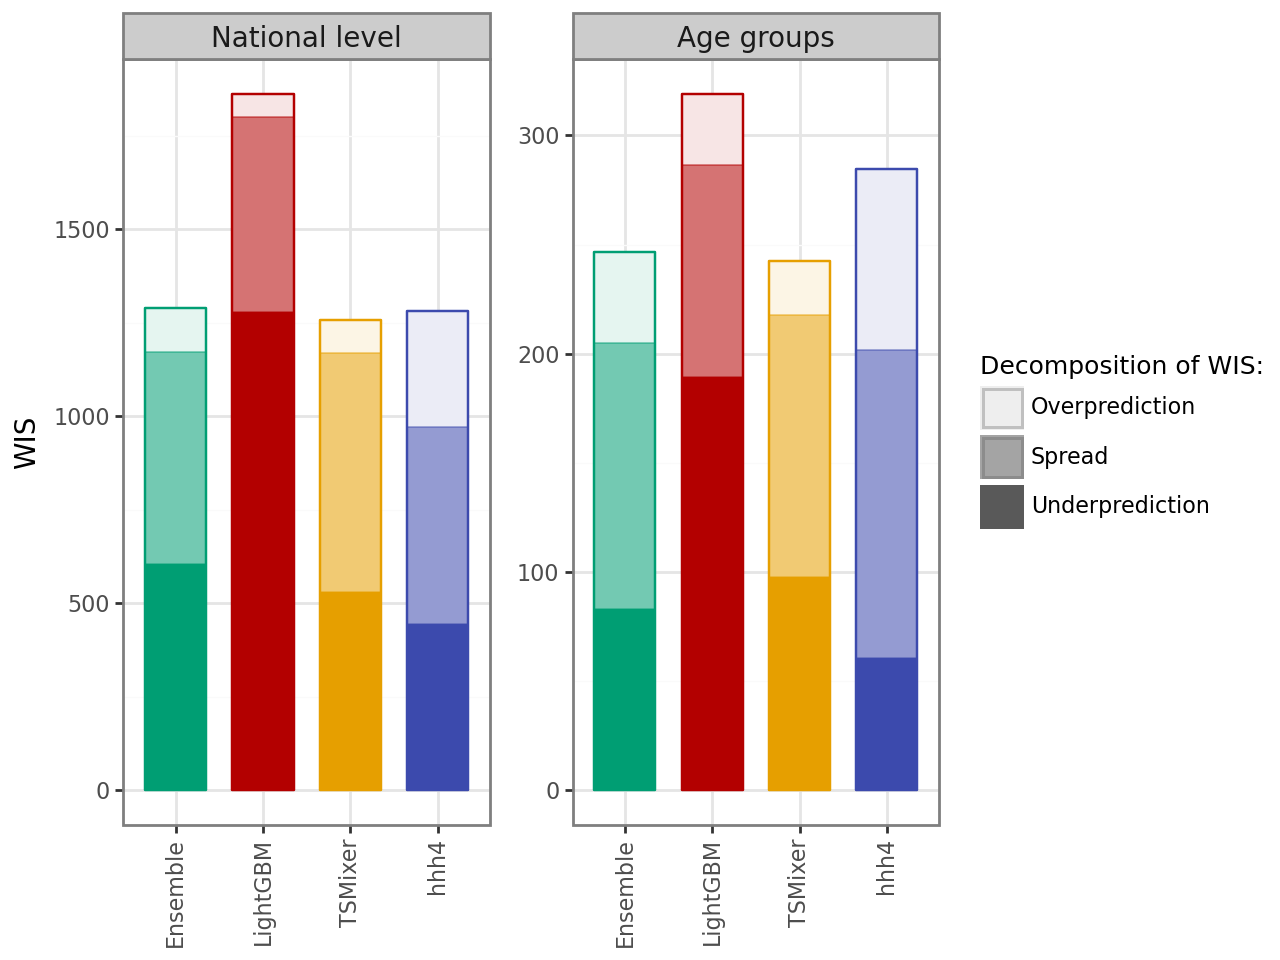

In [85]:
p = plot_total_scores(df_long, models=df.model.unique())
p

In [17]:
# p.save("../figures/wis.pdf", width = 160, height = 70, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 70.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis.pdf


In [86]:
def plot_coverage(df_wide, models=None):
    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide['model'] = pd.Categorical(df_wide['model'], categories=model_order, ordered=True) 
    
    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x='model'))
        + facet_wrap('~level', nrow=1, scales='fixed', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
        + expand_limits(y=1)  # Ensure y-axis starts at 1

        # Add columns for 95% and 50% coverage with respective alpha transparency
        + geom_col(aes(y='c95'), width=0.7, fill='white', show_legend={'fill': False})
        + geom_col(aes(y='c95', fill='model', alpha='"95%"'), width=0.7, show_legend={'fill': False})
        + geom_col(aes(y='c50', fill='model', alpha='"50%"'), width=0.7, show_legend={'fill': False})

        # Horizontal dashed lines at y = 0.5 and y = 0.95
        + geom_hline(yintercept=[0.5, 0.95], linetype='dashed')

        # Customize y-axis labels to display "0" instead of omitting 0
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])

        # Labels for axes, color, and alpha legend
        + labs(
            x='',
            y="Empirical coverage",
            color="Model",
            alpha="Prediction interval: "
        )

        # Conditional color mapping for fill
        + scale_fill_manual(values=MODEL_COLORS)

        # Flip coordinates to make x-axis vertical
        #+ coord_flip()

        # Custom alpha levels for each bar transparency
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=False))

        # Basic theme with customized legend position and alignment
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position='right',
            legend_title_position='top',
            panel_spacing=0.025
        )
    )

    return p

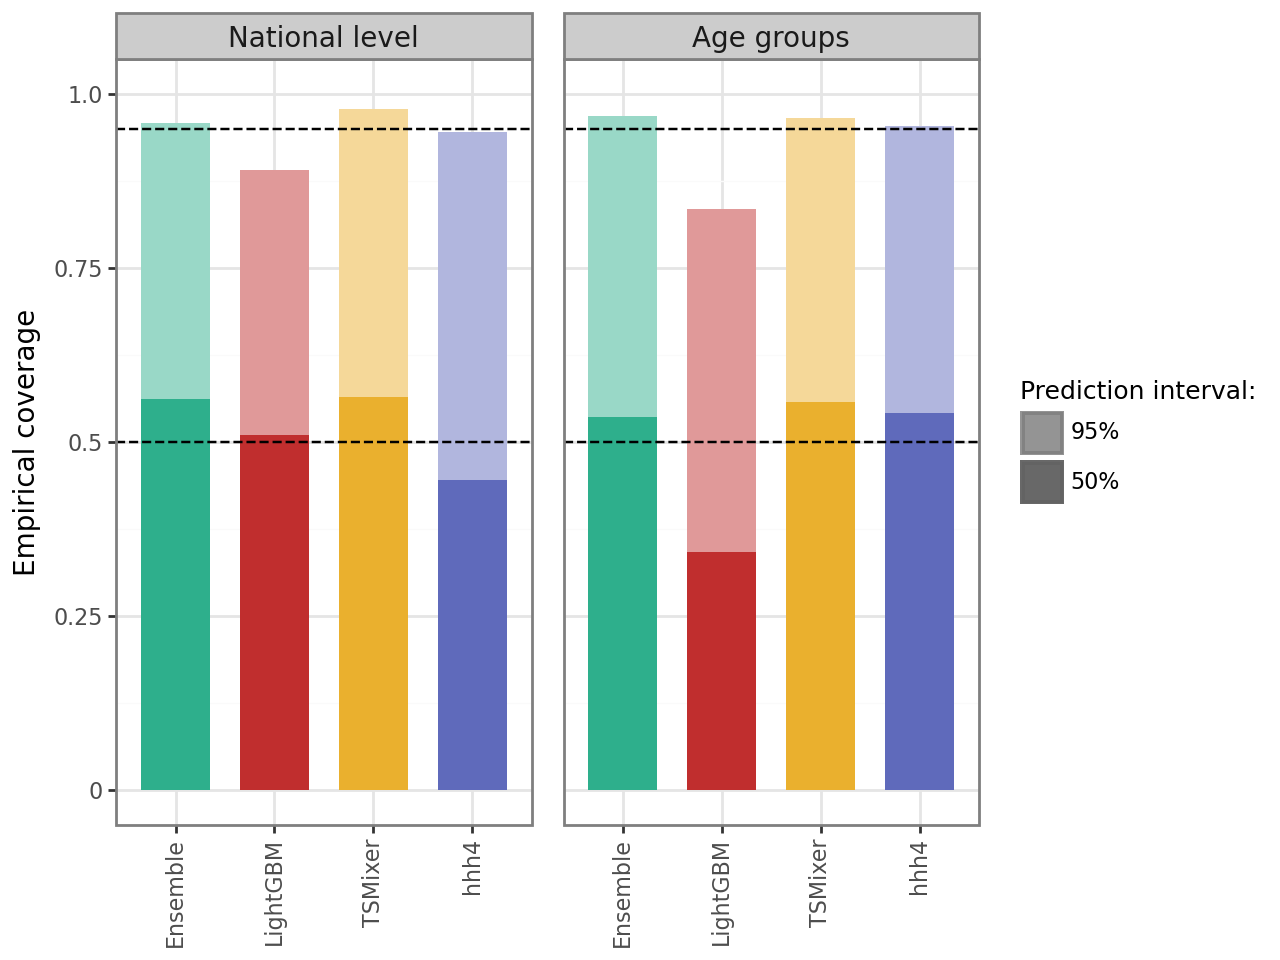

In [87]:
p = plot_coverage(df_wide, MAIN_MODELS)
p

In [20]:
# p.save("../figures/coverage.pdf", width = 160, height = 70, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 70.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/coverage.pdf


## By age group

In [88]:
scores_age = evaluate_models(df, 'age', by_age=True)

In [89]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [90]:
def plot_scores_by_age_group(scores, models=None):
    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores['model'] = pd.Categorical(scores['model'], categories=model_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + custom_theme()
        + theme(legend_position='right',
            legend_title_position='top')
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


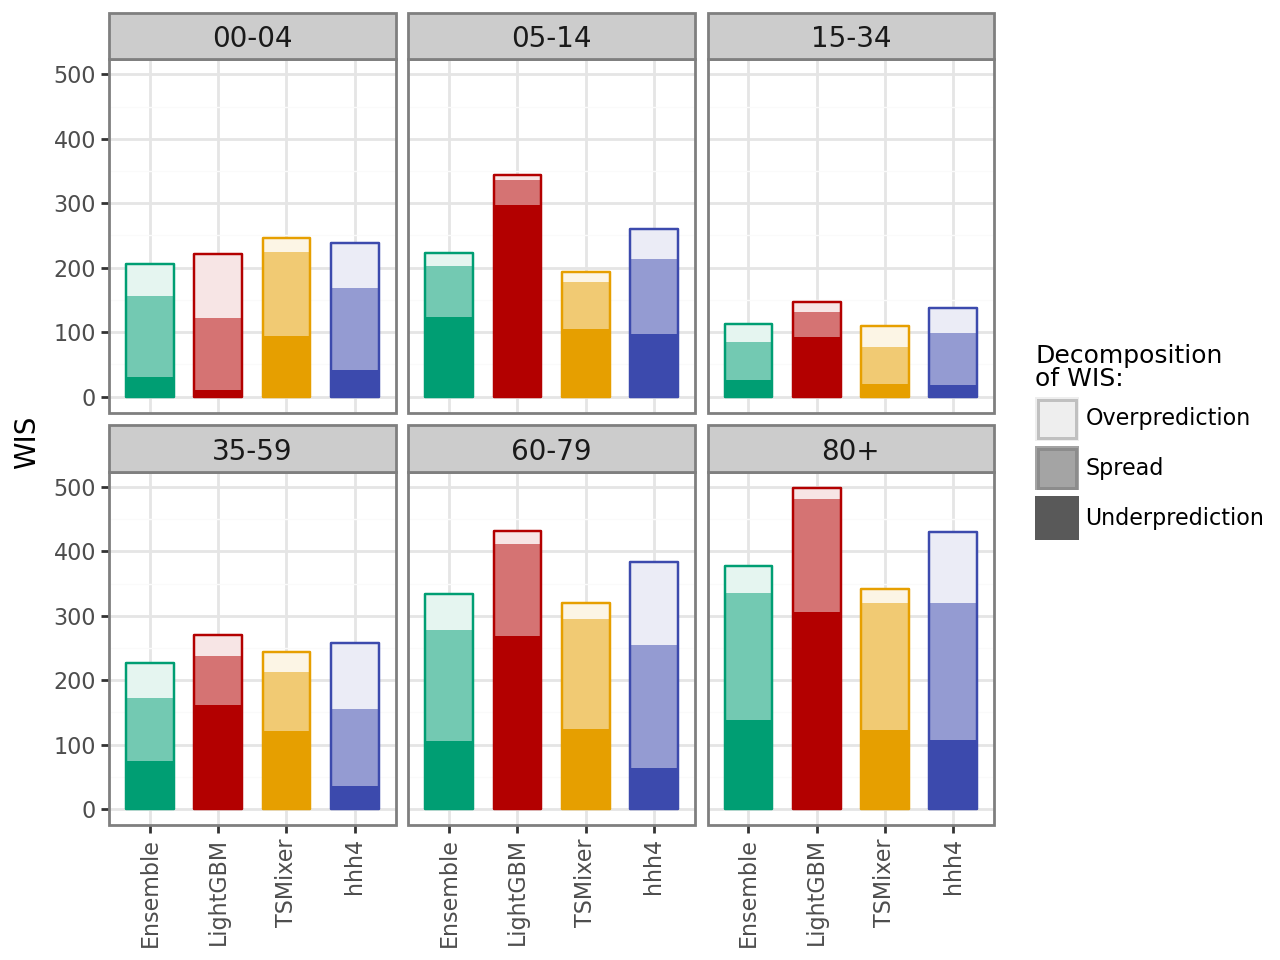

In [91]:
p = plot_scores_by_age_group(scores_age, MAIN_MODELS)
p

In [25]:
#p.save("../figures/wis_age.pdf", width = 160, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf


## By horizon

In [92]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [93]:
def plot_scores_by_horizon_and_model(df, level='national', models=None):
    scores = df[df.level==level].copy()
    
    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores['model'] = pd.Categorical(scores['model'], categories=model_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="WIS by horizon")
        + facet_grid(cols='horizon', scales="free", space='free')  # Create a facet for each horizon
        #+ facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + custom_theme()
        + theme(legend_position='bottom',
                legend_title_position='left',
                # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
                # axis_text_y=element_text(size=7)
               )
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


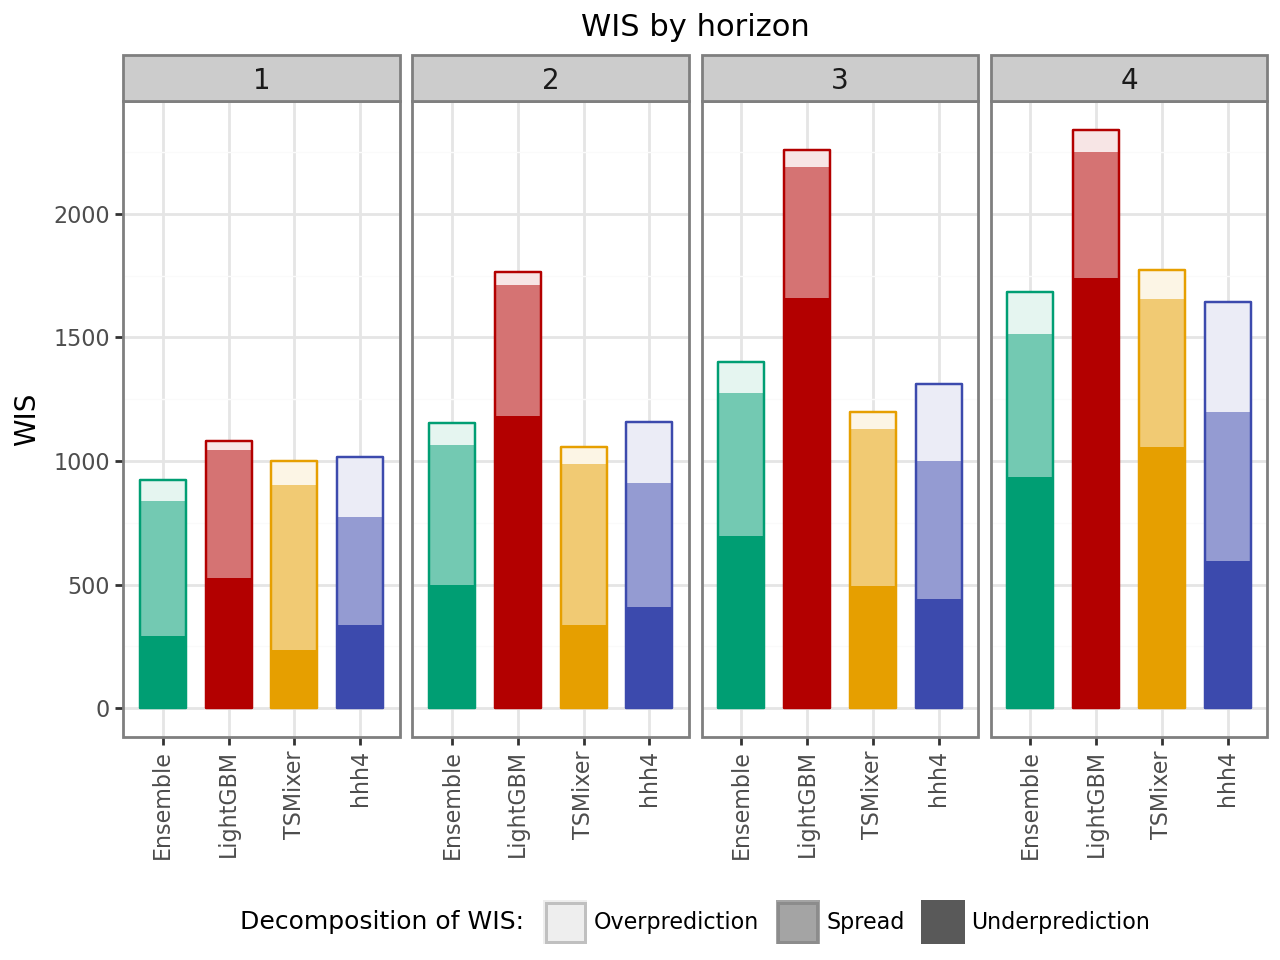

In [94]:
p = plot_scores_by_horizon_and_model(df_long, 'national', ['Nowcast'] + MAIN_MODELS)
p 

In [29]:
#p.save("../figures/wis_national_horizon.pdf", width = 170, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 170.0 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national_horizon.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


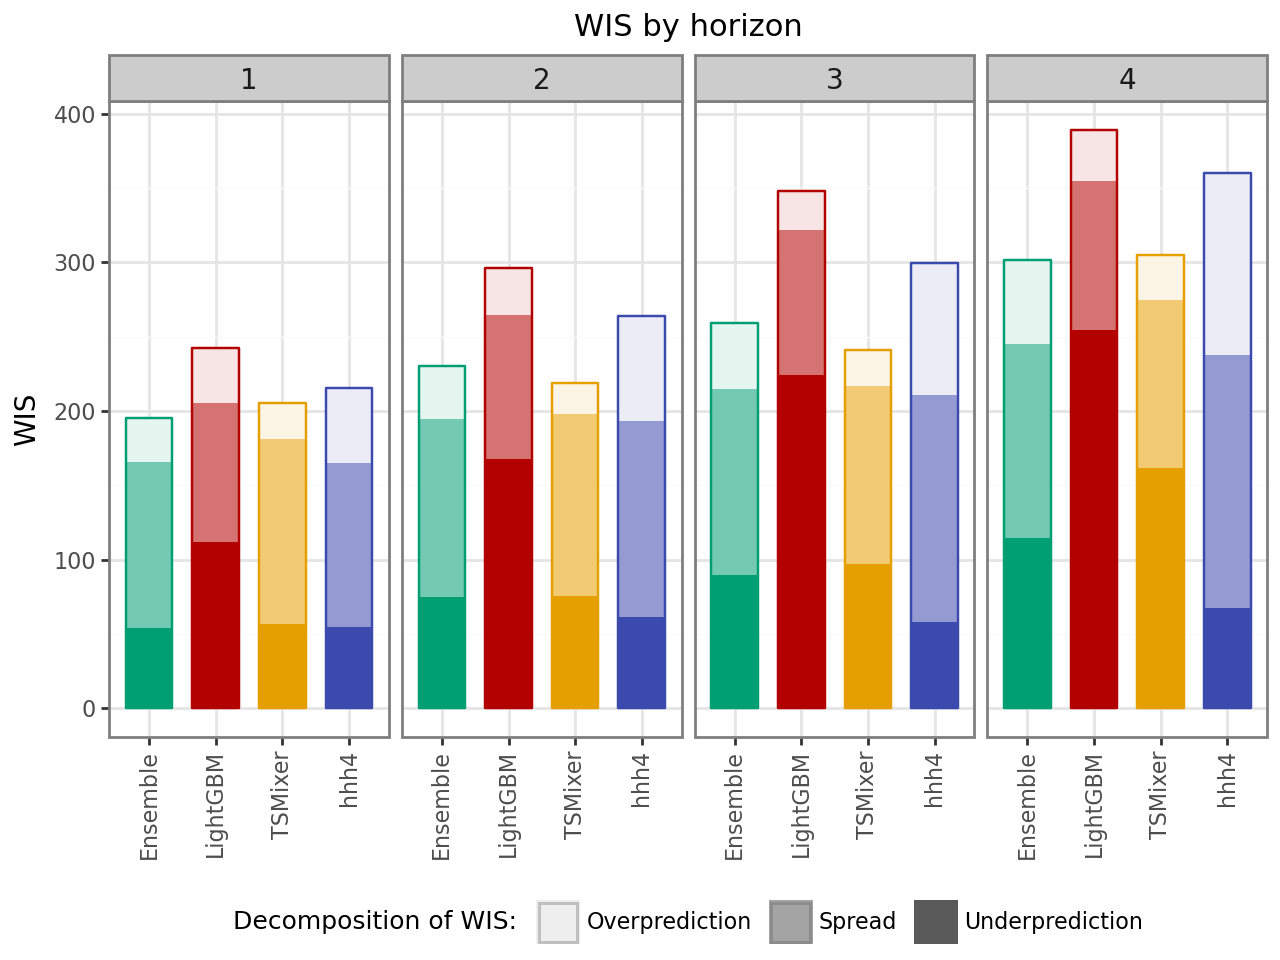

In [95]:
p = plot_scores_by_horizon_and_model(df_long, 'age', ['Nowcast'] + MAIN_MODELS)
p 

In [31]:
# p.save("../figures/wis_age_horizon.pdf", width = 170, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 170.0 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


# Coverage by horizon

In [96]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [97]:
def plot_coverage_by_horizon(df_wide, level='national', models=None):
    df_wide = df_wide[df_wide.level==level].copy()
    
    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide['model'] = pd.Categorical(df_wide['model'], categories=model_order, ordered=True) 
    
    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x='model'))
        + facet_wrap('~level', nrow=1, scales='fixed', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
        + expand_limits(y=1)  # Ensure y-axis starts at 1

        # Add columns for 95% and 50% coverage with respective alpha transparency
        + geom_col(aes(y='c95'), width=0.7, fill='white', show_legend={'fill': False})
        + geom_col(aes(y='c95', fill='model', alpha='"95%"'), width=0.7, show_legend={'fill': False})
        + geom_col(aes(y='c50', fill='model', alpha='"50%"'), width=0.7, show_legend={'fill': False})

        # Horizontal dashed lines at y = 0.5 and y = 0.95
        + geom_hline(yintercept=[0.5, 0.95], linetype='dashed')

        # Customize y-axis labels to display "0" instead of omitting 0
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])

        # Labels for axes, color, and alpha legend
        + labs(
            x='',
            y="Empirical coverage",
            color="Model",
            alpha="Prediction interval: ",
            title="Coverage by horizon"
        )

        # Conditional color mapping for fill
        + scale_fill_manual(values=MODEL_COLORS)

        # Flip coordinates to make x-axis vertical
        #+ coord_flip()

        # Custom alpha levels for each bar transparency
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=True))
        
        # Create a facet for each horizon
        + facet_grid(cols='horizon', scales="free", space='free')  

        # Basic theme with customized legend position and alignment
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position='bottom',
            legend_title_position='left',
            # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
            # axis_text_y=element_text(size=7)
            #panel_spacing=0.025
        )
    )

    return p

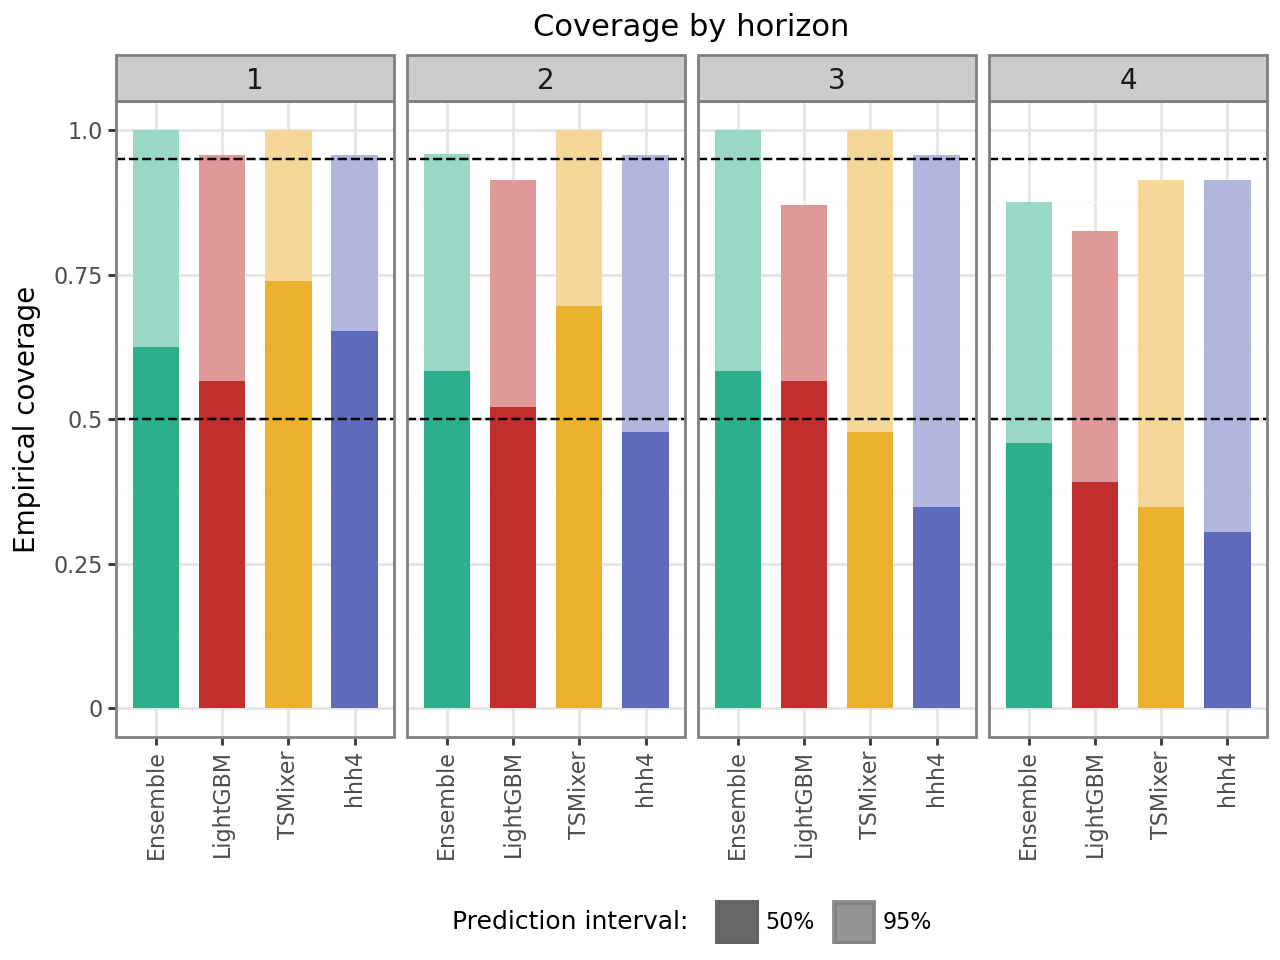

In [98]:
p = plot_coverage_by_horizon(df_wide, 'national', ['Nowcast'] + MAIN_MODELS)
p

In [35]:
# p.save("../figures/coverage_national_horizon.pdf", width = 170, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 170.0 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/coverage_national_horizon.pdf


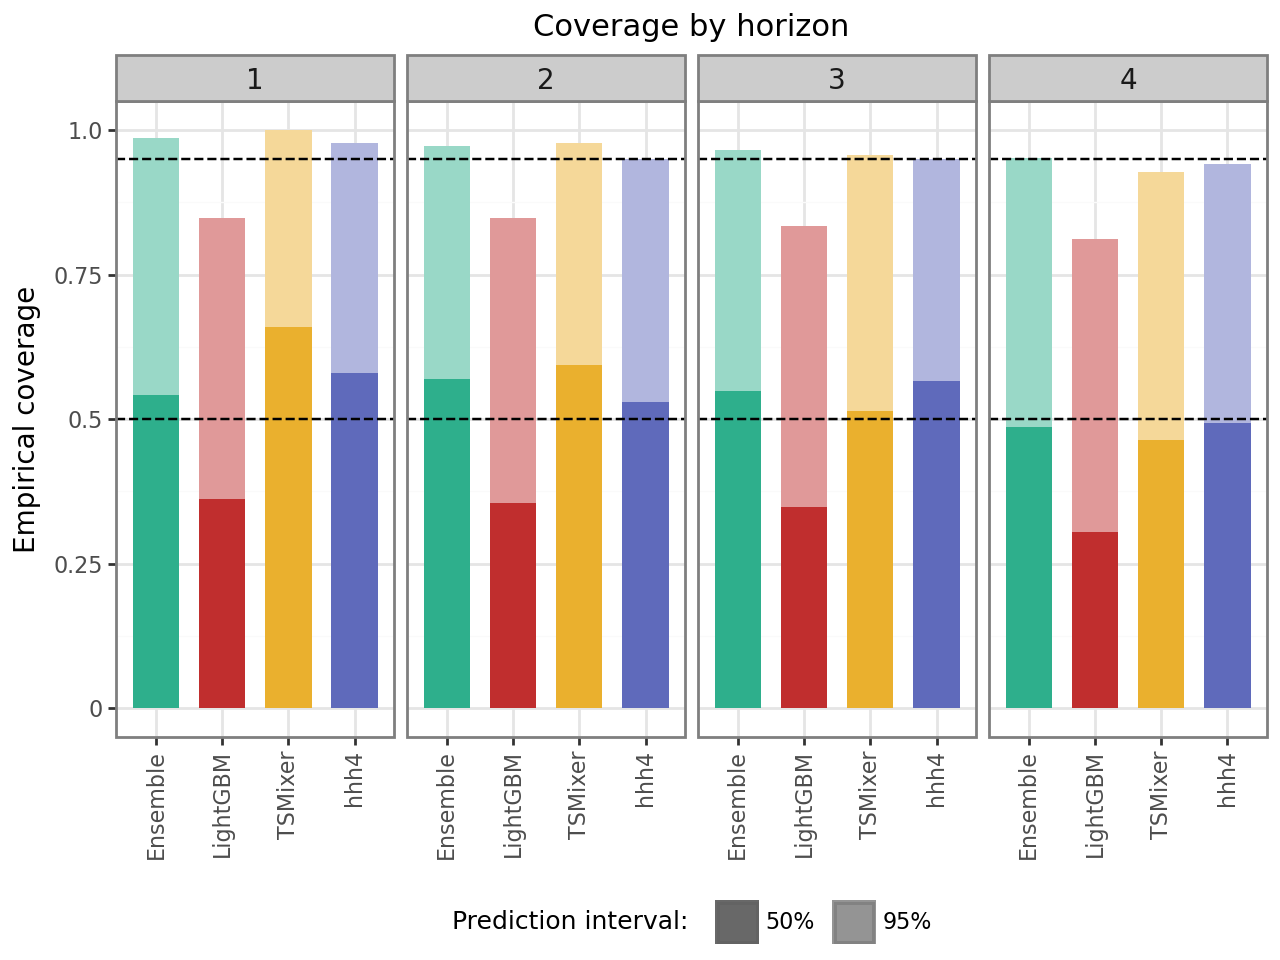

In [99]:
p = plot_coverage_by_horizon(df_wide, 'age', ['Nowcast'] + MAIN_MODELS)
p

In [37]:
# p.save("../figures/coverage_age_horizon.pdf", width = 170, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 170.0 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/coverage_age_horizon.pdf


# Compare model variants

In [38]:
df_national = evaluate_models(df, 'national')
df_age = evaluate_models(df, 'age')

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_wide['level'] = pd.Categorical(df_wide['level'], categories=['national', 'age'], ordered=True)

df_long = pd.melt(df_wide, id_vars=['level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


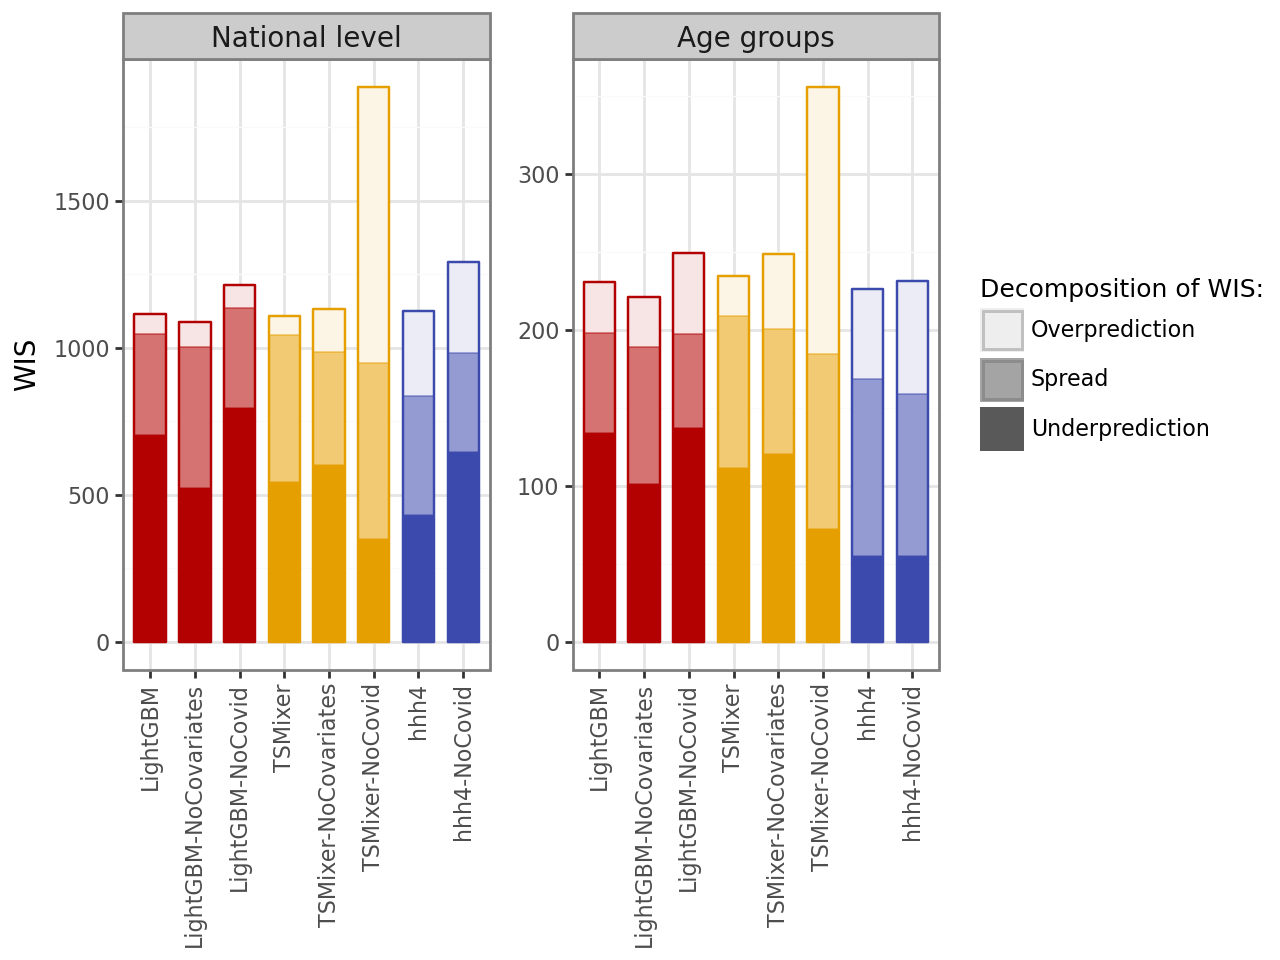

In [39]:
p = plot_total_scores(df_long, models=['LightGBM', 'LightGBM-NoCovariates', 'LightGBM-NoCovid', 'TSMixer', 'TSMixer-NoCovariates', 'TSMixer-NoCovid', 'hhh4', 'hhh4-NoCovid'])
p

In [40]:
p.save("../figures/wis_model_variants.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_model_variants.pdf


# Variants by horizon

In [41]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [42]:
df_long.model.unique()

array(['Nowcast', 'LightGBM-Skip', 'hhh4-Skip', 'TSMixer-Skip',
       'hhh4-Oracle', 'Ensemble', 'LightGBM-Oracle', 'hhh4', 'LightGBM',
       'LightGBM-NoCovariates', 'hhh4-NoCovid', 'TSMixer-NoCovariates',
       'LightGBM-NoCovid', 'Persistence', 'TSMixer-Oracle', 'TSMixer',
       'TSMixer-Uncorrected', 'hhh4-Uncorrected', 'TSMixer-NoCovid',
       'LightGBM-Uncorrected', 'Historical'], dtype=object)

In [43]:
df_long['class'] = df_long.model.apply(lambda x: x.split('-')[0])

In [44]:
df_long['variant'] = df_long.model.apply(lambda x: x.split('-')[-1])

In [45]:
df_long.variant = df_long.variant.replace({'LightGBM': 'Standard', 'TSMixer': 'Standard', 'hhh4': 'Standard'})

In [46]:
df_long.variant.unique()

array(['Nowcast', 'Skip', 'Oracle', 'Ensemble', 'Standard',
       'NoCovariates', 'NoCovid', 'Persistence', 'Uncorrected',
       'Historical'], dtype=object)

In [47]:
df_long['variant'] = pd.Categorical(df_long['variant'], categories=['Nowcast', 'Standard', 'NoCovariates', 'NoCovid','Oracle','Skip', 'Uncorrected',  
        'Ensemble', 'Persistence', 'Historical'], ordered=True)

In [48]:
def plot_variants_by_horizon(df, level='national', models=None, ymax='auto'):
    scores = df[df.level==level].copy()
    
    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores['model'] = pd.Categorical(scores['model'], categories=model_order, ordered=True) 
    
    if ymax == 'auto':
        ymax = scores.value.max()*1.05
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='variant', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='variant', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="WIS by horizon")
        + facet_grid(cols='horizon', rows='class', scales="free", space='free')  # Create a facet for each horizon
        #+ facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + custom_theme()
        + theme(legend_position='bottom',
                legend_title_position='left',
                # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
                # axis_text_y=element_text(size=7)
               )
        + ylim(0, ymax)
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


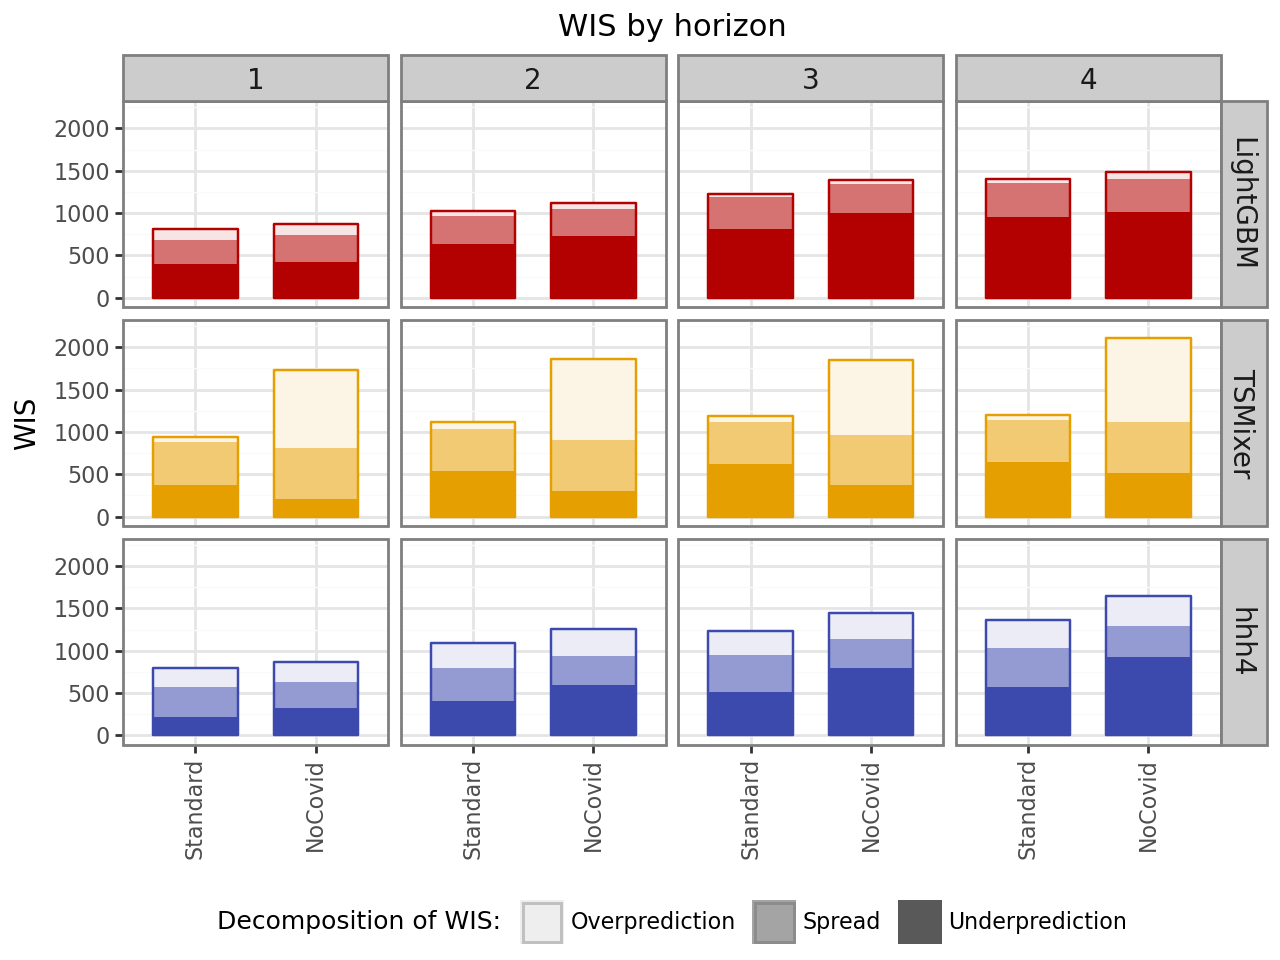

In [49]:
p = plot_variants_by_horizon(df_long[df_long.horizon >= 0], 'national', ['LightGBM', 'LightGBM-NoCovid', 
                                                      'TSMixer', 'TSMixer-NoCovid', 
                                                      'hhh4', 'hhh4-NoCovid'])
p 

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


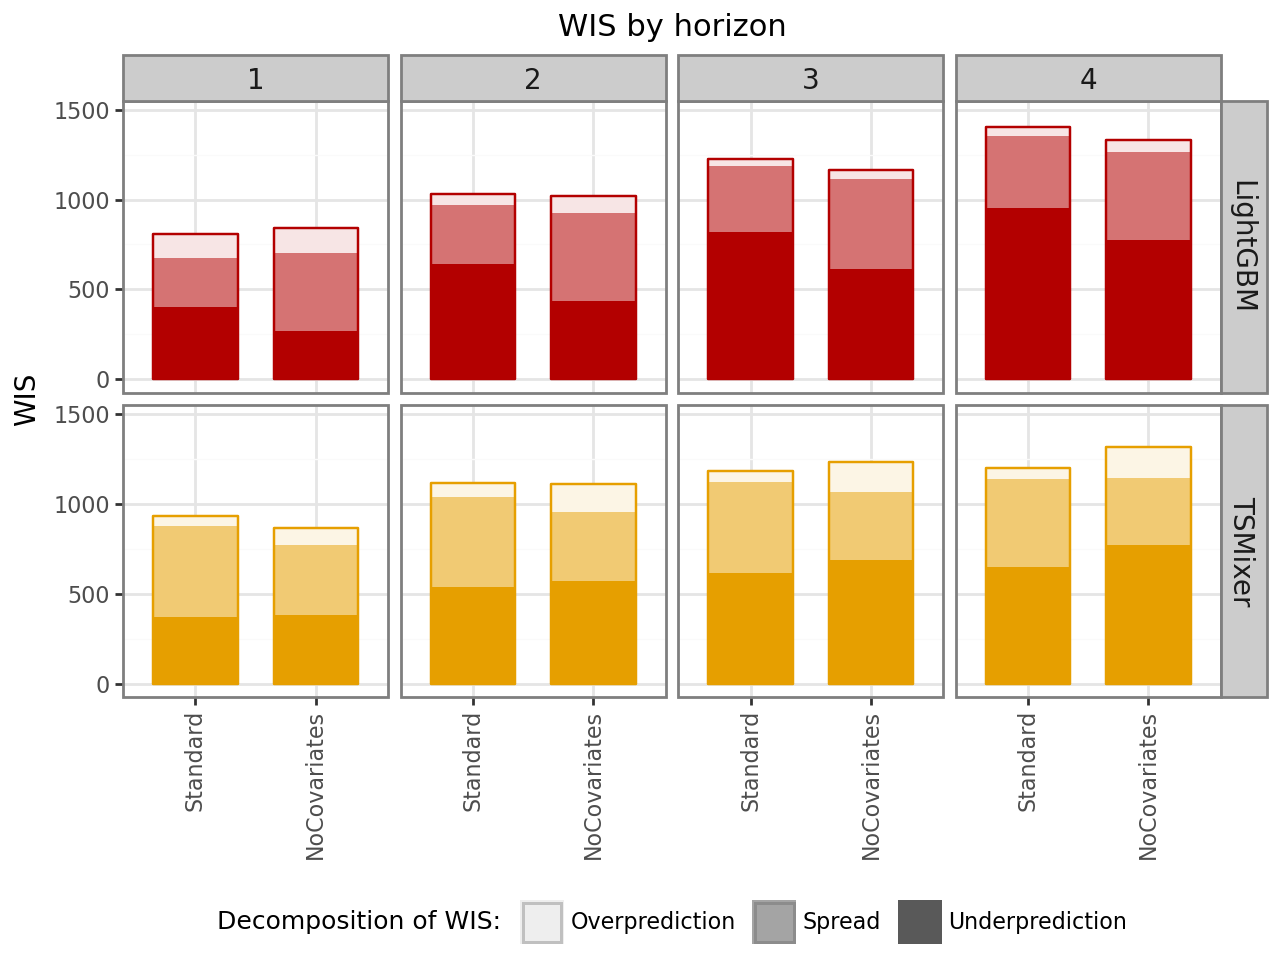

In [50]:
p = plot_variants_by_horizon(df_long[df_long.horizon >= 0], 'national', ['LightGBM', 'LightGBM-NoCovariates',
                                                      'TSMixer', 'TSMixer-NoCovariates'])
p 

In [49]:
df_long2 = df_long[df_long.horizon >= 0].copy()

df_now = df_long2[df_long2.model == 'Nowcast'].copy()

df_now['class'] = 'LightGBM'

for c in ['LightGBM', 'TSMixer', 'hhh4']:
    df_now['class'] = c
    df_long2 = pd.concat([df_long2, df_now])

df_long2 = df_long2[df_long2['class'] != 'Nowcast']

In [50]:
df_long2.variant = df_long2.variant.cat.rename_categories({'Standard': 'Coupling', 'Skip': 'Discard', 'Uncorrected': 'Naive'})

In [51]:
df_long2.model.unique()

array(['LightGBM-Skip', 'hhh4-Skip', 'TSMixer-Skip', 'hhh4-Oracle',
       'Ensemble', 'LightGBM-Oracle', 'hhh4', 'LightGBM',
       'LightGBM-NoCovariates', 'hhh4-NoCovid', 'TSMixer-NoCovariates',
       'LightGBM-NoCovid', 'Persistence', 'TSMixer-Oracle', 'TSMixer',
       'TSMixer-Uncorrected', 'hhh4-Uncorrected', 'TSMixer-NoCovid',
       'LightGBM-Uncorrected', 'Historical', 'Nowcast'], dtype=object)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


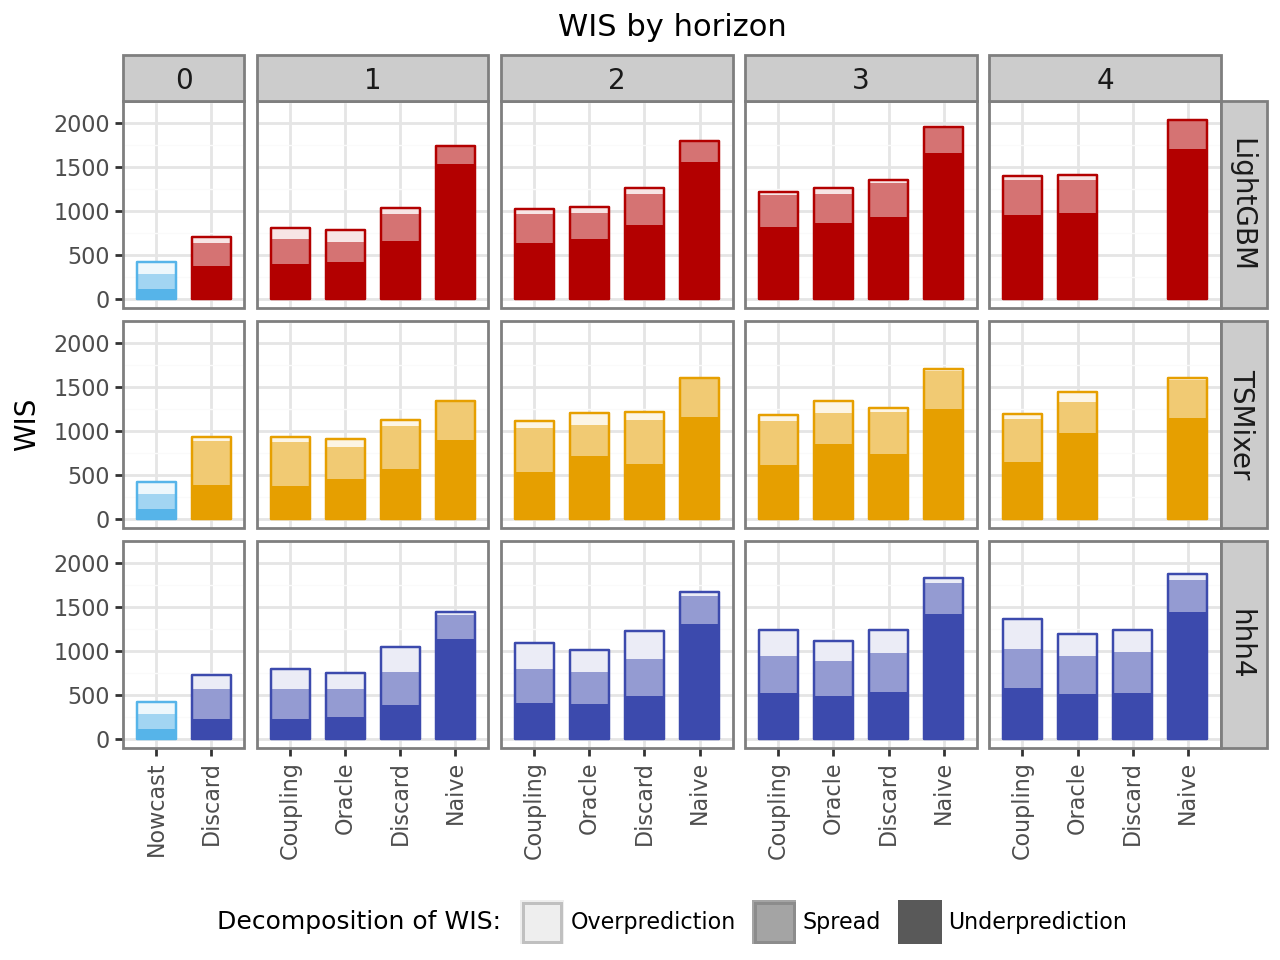

In [52]:
p = plot_variants_by_horizon(df_long2, 'national', ['LightGBM', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected',
                                                      'TSMixer', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',
                                                      'hhh4', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected', 'Nowcast'])
p 

In [53]:
p.save("../figures/wis_variants_horizon.pdf", width = 130, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 130.00000000000003 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_variants_horizon.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


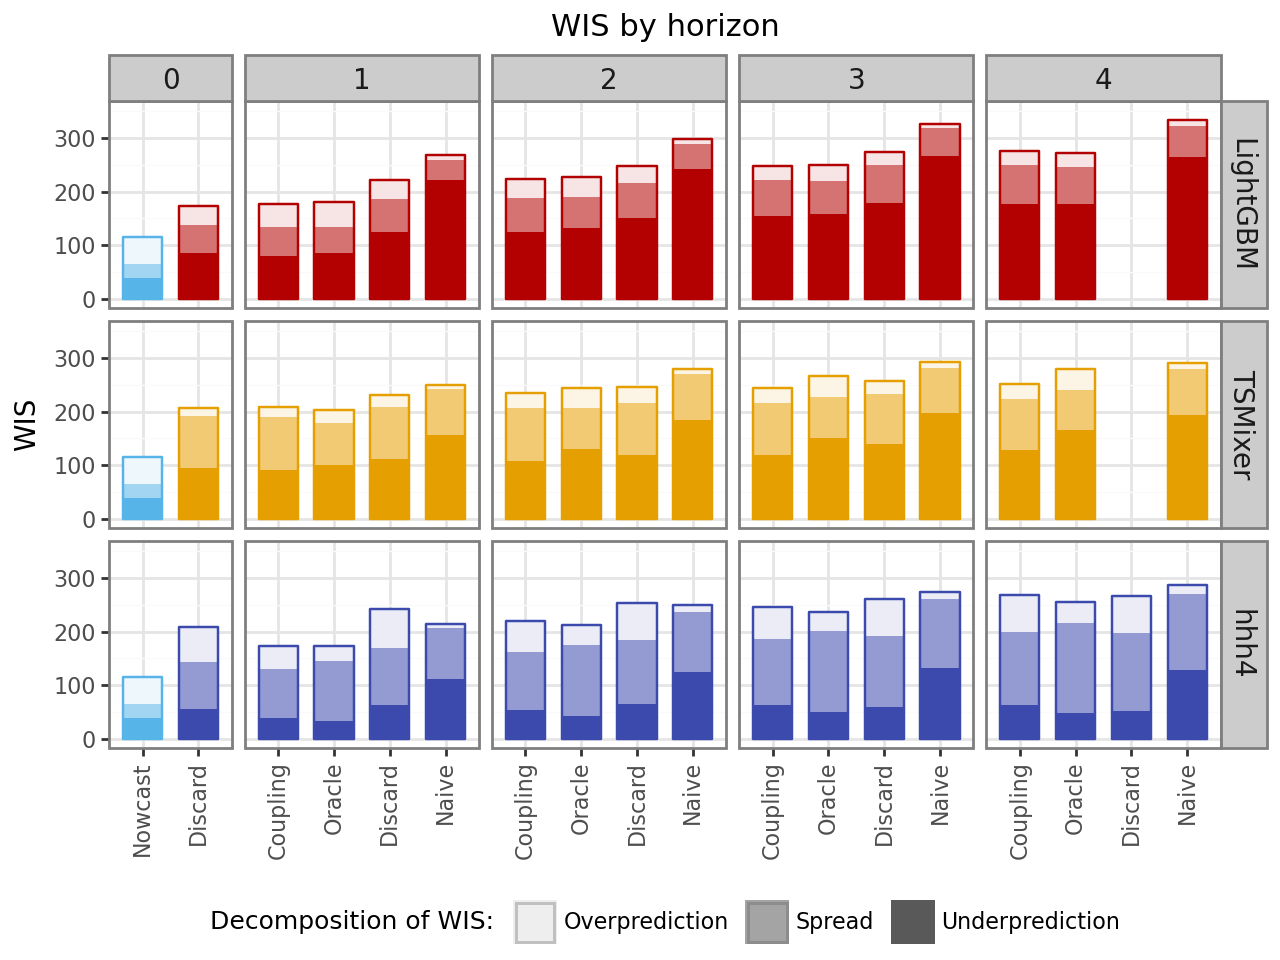

In [54]:
p = plot_variants_by_horizon(df_long2, 'age', ['LightGBM', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected',
                                                      'TSMixer', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',
                                                      'hhh4', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected', 'Nowcast'])
p 

In [55]:
p.save("../figures/wis_variants_horizon_age.pdf", width = 130, height = 100, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 130.00000000000003 x 100.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_variants_horizon_age.pdf
